# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

## Анализ данных

In [1]:
import numpy as np
import pandas as pd

import os
 
from PIL import Image
import matplotlib.pyplot as plt
 
 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

<AxesSubplot:title={'center':'Age distribution'}, xlabel='Age', ylabel='Count'>

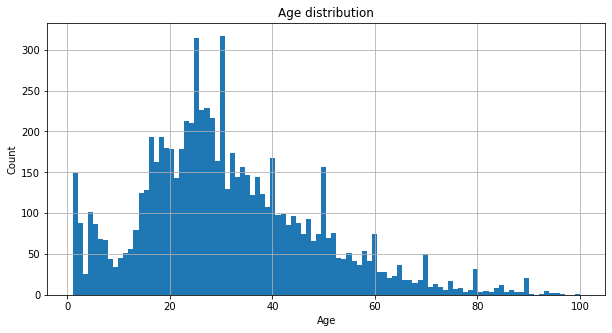

In [4]:
plt.figure(figsize=(10, 5))
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
labels.real_age.hist(bins=100)

In [5]:
rows = 5
columns = 4
images = labels.sample(rows*columns, random_state=12345)

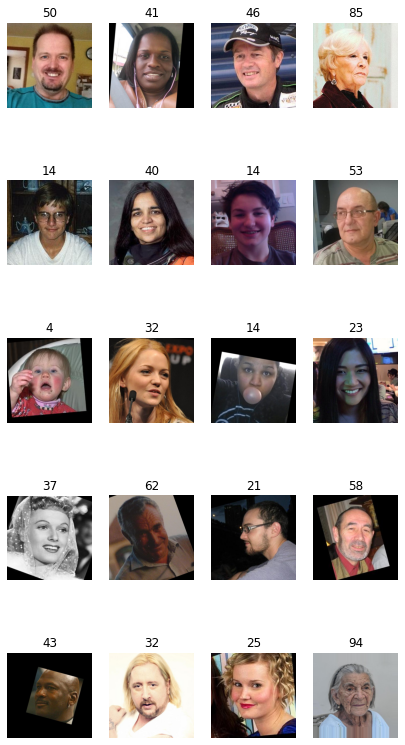

In [6]:
fig = plt.figure(figsize=(7, 14))
for i in range(columns*rows):
    img = Image.open(os.path.join('/datasets/faces/final_files/', images.iloc[i]['file_name']))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(images.iloc[i]['real_age'])
plt.show()

В выборке было предоставлено 7591 изображение.

По распределению, можно отметить, что наибольшее количество фотографий примерно от 17 до 40 лет.

По такому распределению, можно сказать, что возраста, которые входят в этот диапазон будут определяться с наименьшим значением ошибки.

## Обучение модели

In [7]:
# создаём генератор тренировочной выборки
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


# создаём генератор тестовой выборки
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


# создаём модель
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0002)
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model




# обучаем модель
def train_model(model, train_data, test_data, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

### Процесс обучения

Процесс обучения выглядел следующим образом:

Train for 356 steps, validate for 119 steps\
Epoch 1/30

356/356 - 48s - loss: 200.0438 - mae: 10.4832 - val_loss: 393.4021 - val_mae: 14.8510
Epoch 2/30

356/356 - 39s - loss: 97.6563 - mae: 7.5439 - val_loss: 211.9959 - val_mae: 11.7831
Epoch 3/30

356/356 - 39s - loss: 72.6696 - mae: 6.5042 - val_loss: 120.5225 - val_mae: 8.5848
Epoch 4/30

356/356 - 42s - loss: 51.7706 - mae: 5.4886 - val_loss: 101.6648 - val_mae: 7.3679
Epoch 5/30

356/356 - 56s - loss: 44.1724 - mae: 5.0733 - val_loss: 91.9339 - val_mae: 7.2036
Epoch 6/30

356/356 - 50s - loss: 32.9695 - mae: 4.3947 - val_loss: 74.3034 - val_mae: 6.4470
Epoch 7/30

356/356 - 46s - loss: 27.6296 - mae: 4.0176 - val_loss: 86.1207 - val_mae: 6.8310
Epoch 8/30

356/356 - 57s - loss: 25.2710 - mae: 3.7795 - val_loss: 118.3852 - val_mae: 8.1764
Epoch 9/30

356/356 - 45s - loss: 24.7658 - mae: 3.7911 - val_loss: 77.4605 - val_mae: 6.6889
Epoch 10/30

356/356 - 53s - loss: 19.2033 - mae: 3.3488 - val_loss: 74.3579 - val_mae: 6.5568
Epoch 11/30

356/356 - 56s - loss: 16.9020 - mae: 3.0997 - val_loss: 76.4531 - val_mae: 6.5362
Epoch 12/30

356/356 - 43s - loss: 14.8418 - mae: 2.9403 - val_loss: 72.8383 - val_mae: 6.3507
Epoch 13/30

356/356 - 57s - loss: 14.7441 - mae: 2.9341 - val_loss: 72.5340 - val_mae: 6.4192
Epoch 14/30

356/356 - 50s - loss: 14.6467 - mae: 2.9197 - val_loss: 74.1148 - val_mae: 6.6313
Epoch 15/30

356/356 - 43s - loss: 13.3679 - mae: 2.7726 - val_loss: 76.2785 - val_mae: 6.5460
Epoch 16/30

356/356 - 40s - loss: 13.4769 - mae: 2.8027 - val_loss: 71.0379 - val_mae: 6.2082
Epoch 17/30

356/356 - 39s - loss: 13.8185 - mae: 2.8334 - val_loss: 68.6706 - val_mae: 6.0800
Epoch 18/30

356/356 - 39s - loss: 14.0902 - mae: 2.8562 - val_loss: 72.9806 - val_mae: 6.4105
Epoch 19/30

356/356 - 39s - loss: 13.1994 - mae: 2.7719 - val_loss: 75.6683 - val_mae: 6.6818
Epoch 20/30

356/356 - 42s - loss: 13.8992 - mae: 2.8190 - val_loss: 91.8275 - val_mae: 7.5432
Epoch 21/30

356/356 - 51s - loss: 12.6113 - mae: 2.7112 - val_loss: 67.5959 - val_mae: 6.0438
Epoch 22/30

356/356 - 52s - loss: 12.5270 - mae: 2.6911 - val_loss: 67.9639 - val_mae: 6.0554
Epoch 23/30

356/356 - 49s - loss: 11.2943 - mae: 2.5674 - val_loss: 64.4464 - val_mae: 5.8939
Epoch 24/30

356/356 - 46s - loss: 10.1057 - mae: 2.4286 - val_loss: 83.5018 - val_mae: 6.6768
Epoch 25/30

356/356 - 57s - loss: 9.5470 - mae: 2.3133 - val_loss: 65.8904 - val_mae: 6.1139
Epoch 26/30

356/356 - 56s - loss: 8.5980 - mae: 2.2223 - val_loss: 70.5756 - val_mae: 6.1588
Epoch 27/30

356/356 - 43s - loss: 12.6744 - mae: 2.6907 - val_loss: 90.3446 - val_mae: 7.3309
Epoch 28/30

356/356 - 57s - loss: 14.8036 - mae: 2.8616 - val_loss: 62.2617 - val_mae: 5.8598
Epoch 29/30

356/356 - 56s - loss: 31.0333 - mae: 3.9707 - val_loss: 82.3344 - val_mae: 6.8376
Epoch 30/30

356/356 - 39s - loss: 14.0515 - mae: 2.8266 - val_loss: 69.2473 - val_mae: 6.1924

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

119/119 - 10s - loss: 69.2473 - mae: 6.1924

Test MAE: 6.1924

<div style="border:solid orange 2px; padding: 20px">

## Вывод

В итоге, после подбора различных вариаций архитектуры нейронной сети, неплохой результат показал сеть RESnet50 с 4 дополнительными полносвязными слоями. Такая сеть на 30 эпохах обучения показала результат mae на тестовой выборке = 6.2. Такой результат потерь удовлетворяет поставленному условия в mae < 7.